# Classification Metric : Development & Test

## General

### Imports

In [26]:
import pyvdirs.dirs as dirs
import sys
import os
sys.path.insert(0, dirs.SYSTEM_HOME)
sys.path.insert(0, os.path.join(dirs.SYSTEM_HOME, "ToyExample"))

import copy
import pickle
import builtins
import numpy as np
import torch
import matplotlib.pyplot as plt
import pyvtools.text as vtext
import math

import ToyExample.dnnlib.util as dnnlib
from ToyExample.torch_utils import persistence
import ToyExample.training.phema as phema

import ToyExample.toy_example as toy

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Parameters

In [2]:
# Network parameters
classes='A'
num_layers=4
hidden_dim=64
batch_size=4<<10
total_iter=4<<10

# Distribution parameters
P_mean=-2.3
P_std=1.5
sigma_data=0.5
sigma_max=5
lr_ref=1e-2
lr_iter=512
ema_std=0.010

# Guidance parameters
guidance=False
guidance_weight=3
guide_path=os.path.join(dirs.MODELS_HOME, "ToyExample", "10_EarlyStopACID", "Ref", "iter0512.pkl")
guide_interpolation=False

# ACID parameters
acid=False
acid_n=16
acid_f=0.8
acid_diff=True
acid_inverted=False

# Training parameters
val_batch_size=4<<7
test_batch_size=4<<8

# Other parameters
device=torch.device('cuda')
fig1_kwargs = dict(view_x=0.30, view_y=0.30, view_size=1.2, device=device)
fig2_kwargs = dict(view_x=0.45, view_y=1.22, view_size=0.3, device=device)#, sample_distance=0.045, sigma_max=0.03)
seed=0

In [3]:
# Set random seed, if specified
if seed is not None:
    print("Seed = ", seed)
    torch.manual_seed(seed)
    generator = torch.Generator(device).manual_seed(seed)
    np.random.seed(seed)

Seed =  0


In [4]:
guide_path

'/media/vale/QuickData/Vale/Training/models/SCID/ToyExample/10_EarlyStopACID/Ref/iter0512.pkl'

In [30]:
# Initialize models
gtd, gtd_comps = toy.gt(classes, device)
net = toy.ToyModel(num_layers=num_layers, hidden_dim=hidden_dim, sigma_data=sigma_data).to(device).train().requires_grad_(True)
ema = copy.deepcopy(net).eval().requires_grad_(False)
opt = torch.optim.Adam(net.parameters(), betas=(0.9, 0.99))
if guide_path is not None:
    with builtins.open(guide_path, "rb") as f:
        guide = pickle.load(f).to(device)
    print("Guide model loaded from", guide_path)
else:
    guide = None
if guidance and acid:
    ref = guide
    print("Guide model assigned as ACID reference")
elif acid: 
    ref = ema
    print("EMA assigned as ACID reference")
else: ref = None

Guide model loaded from /media/vale/QuickData/Vale/Training/models/SCID/ToyExample/10_EarlyStopACID/Ref/iter0512.pkl


## Plots

In [29]:
print("Original threshold for logp is set to", -2.12, "meaning probability density of", math.exp(-2.12))

Original threshold for logp is set to -2.12 meaning probability density of 0.12003162851145673


In [31]:
gtd_comps

[{'cls': 'A',
  'phi': 0.2676613417115205,
  'mu': array([0.02134411, 0.06333431]),
  'Sigma': array([[0.00034676, 0.00010358],
         [0.00010358, 0.00038515]]),
  'depth': 0},
 {'cls': 'A',
  'phi': 0.2676613417115205,
  'mu': array([0.05188869, 0.09552517]),
  'Sigma': array([[0.00034676, 0.00010358],
         [0.00010358, 0.00038515]]),
  'depth': 0},
 {'cls': 'A',
  'phi': 0.2676613417115205,
  'mu': array([0.08243328, 0.12771604]),
  'Sigma': array([[0.00034676, 0.00010358],
         [0.00010358, 0.00038515]]),
  'depth': 0},
 {'cls': 'A',
  'phi': 0.2676613417115205,
  'mu': array([0.11297786, 0.1599069 ]),
  'Sigma': array([[0.00034676, 0.00010358],
         [0.00010358, 0.00038515]]),
  'depth': 0},
 {'cls': 'A',
  'phi': 0.2676613417115205,
  'mu': array([0.14352244, 0.19209777]),
  'Sigma': array([[0.00034676, 0.00010358],
         [0.00010358, 0.00038515]]),
  'depth': 0},
 {'cls': 'A',
  'phi': 0.2676613417115205,
  'mu': array([0.17406703, 0.22428864]),
  'Sigma': array

In [ ]:
math.erf()

(0.3, 0.3) : 2.0693705081939697 : 7.9198360764480915
(0.2, 0.2) : 0.48671233654022217 : 1.6269585255381334
(0.3, 0.2) : -16.56256103515625 : 6.411669624112501e-08
(0.4, 0.2) : -3.1475229263305664 : 0.042958406318854316
(0.3, 0.1) : -56.93898391723633 : 1.8694483878925558e-25


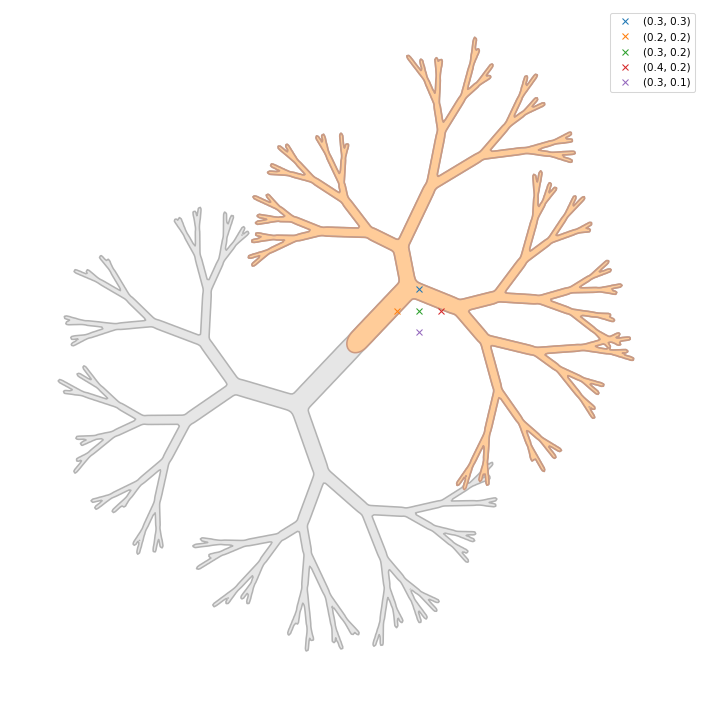

In [27]:
points = [(.3,.3), (.2,.2), (.3,.2), (.4,.2), (.3,.1)]

fig = plt.figure(figsize=[12, 12], dpi=75)
toy.do_plot(ema, elems={'gt_uncond', 'gt_outline'}, figure=fig, device=device)
for p in points:
    gt_logp = float(gtd.logp(torch.Tensor(p).reshape((1,2)).to(device)))
    print(p, ":", gt_logp, ":", math.exp(gt_logp))
    plt.plot(*p,"x",label=str(p))
plt.legend()

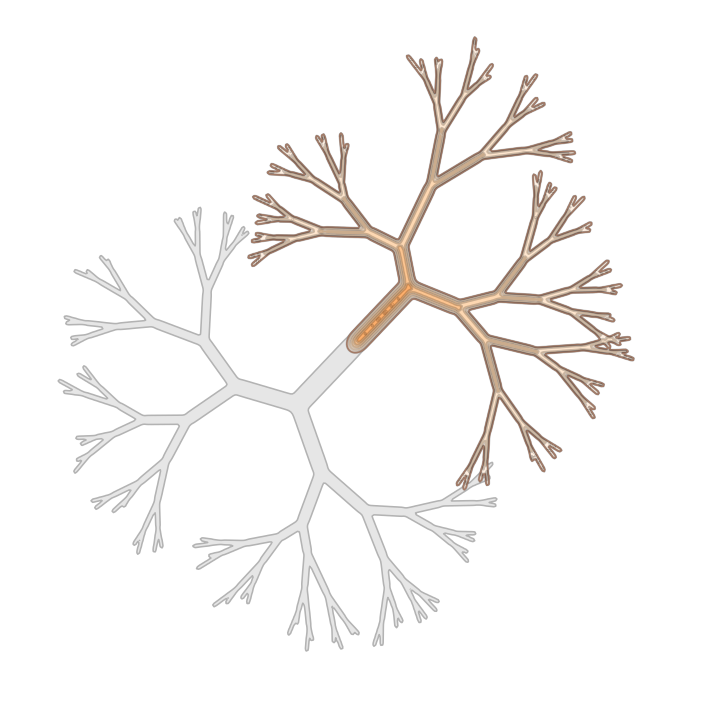

In [37]:
fig = plt.figure(figsize=[12, 12], dpi=75)
toy.do_plot(ema, elems={'gt_uncond', 'gt_outline', 'gt_shaded'}, figure=fig, device=device)

## Old plots

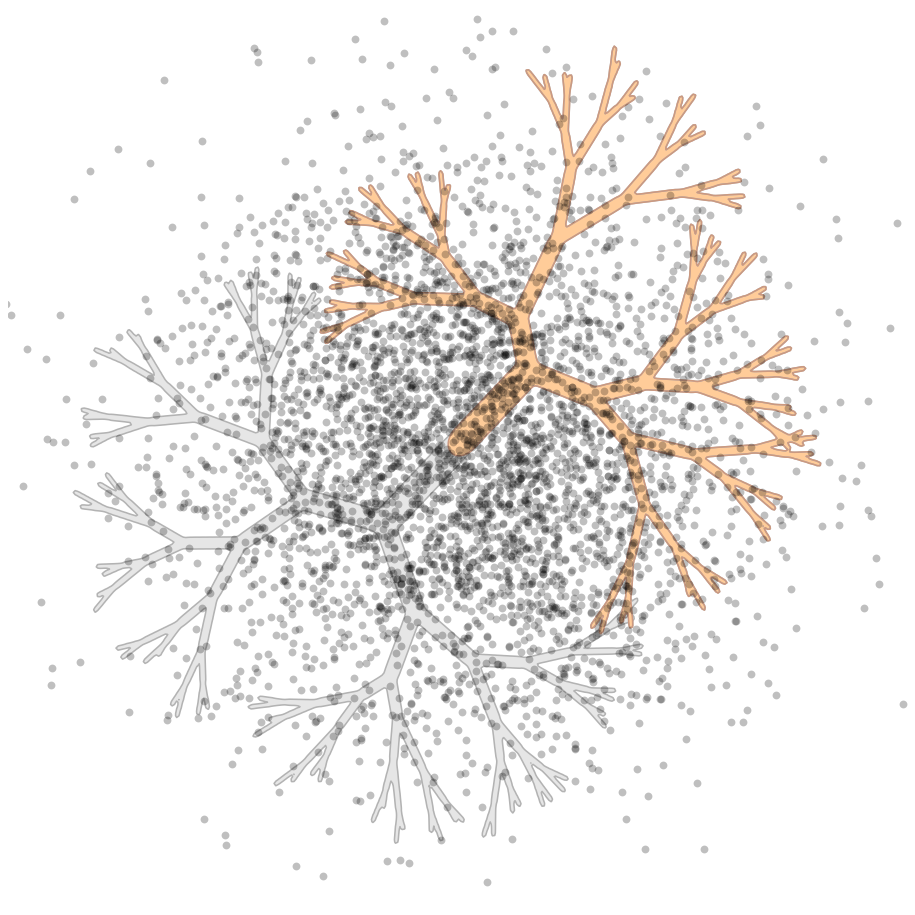

In [12]:
plt.figure(figsize=[12, 12], dpi=75)
toy.do_plot(ema, elems={'samples','gt_uncond', 'gt_outline'}, 
            sigma_max=sigma_max, device=device, num_samples=1<<12)

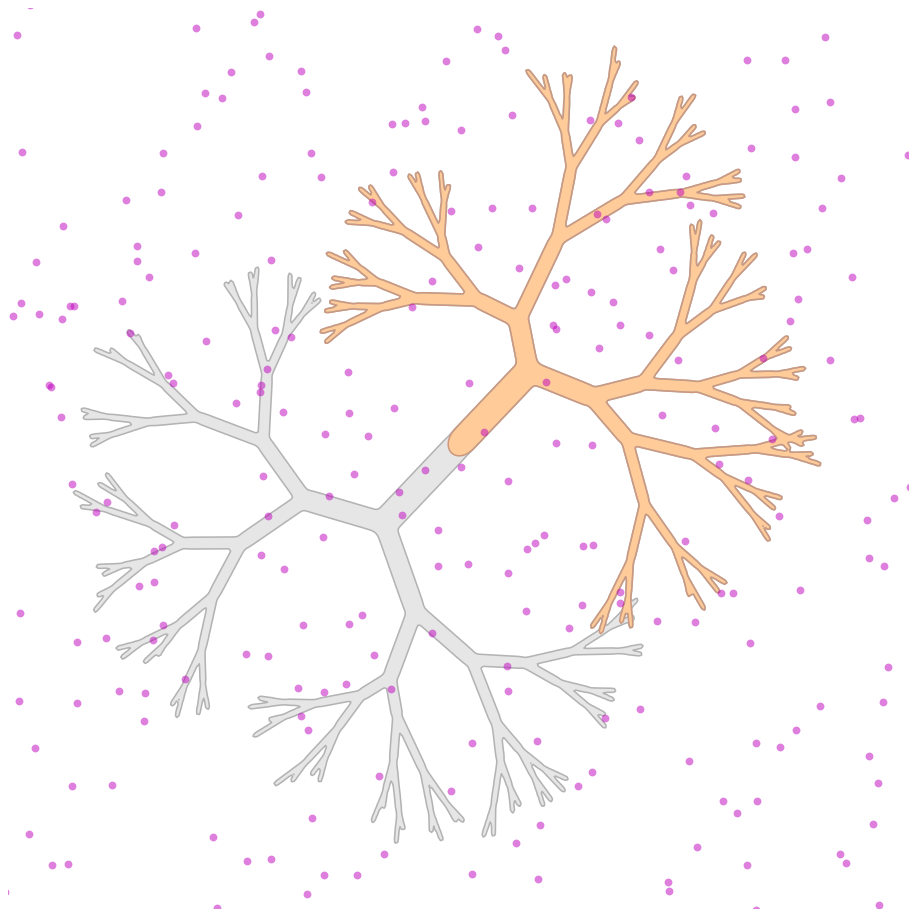

In [ ]:
plt.figure(figsize=[12, 12], dpi=75)
toy.do_plot(ema, elems={'samples_before_small','gt_uncond', 'gt_outline'}, num_samples=1<<12)

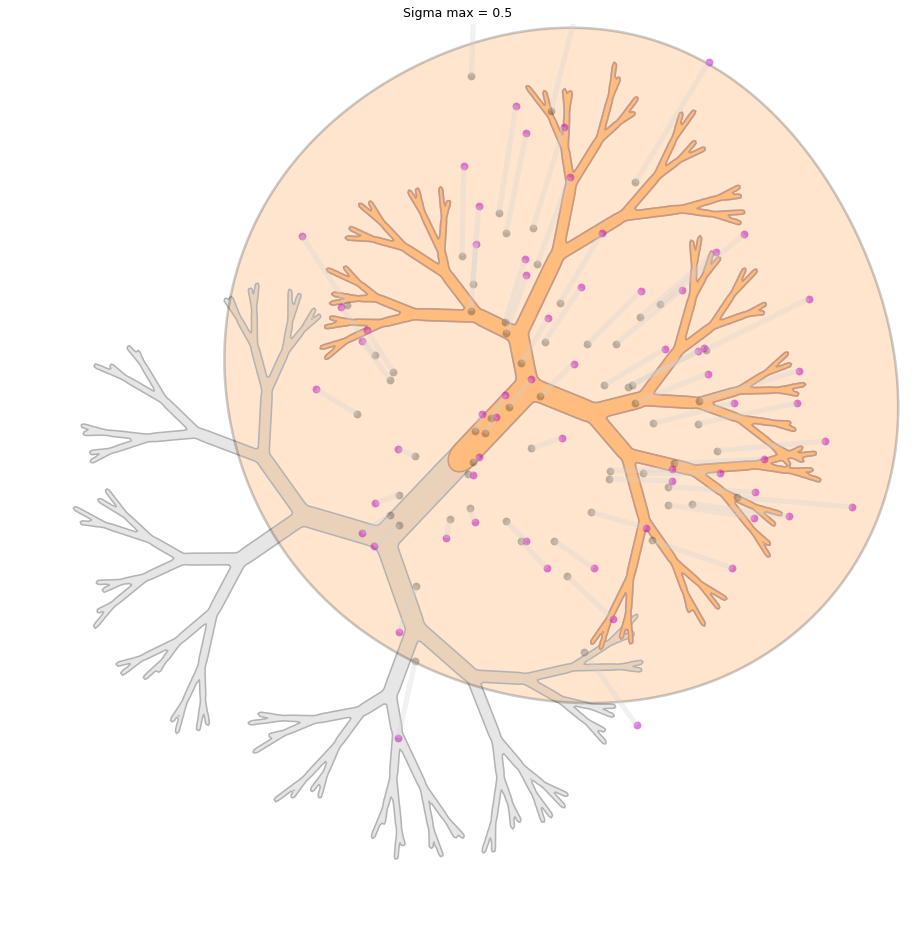

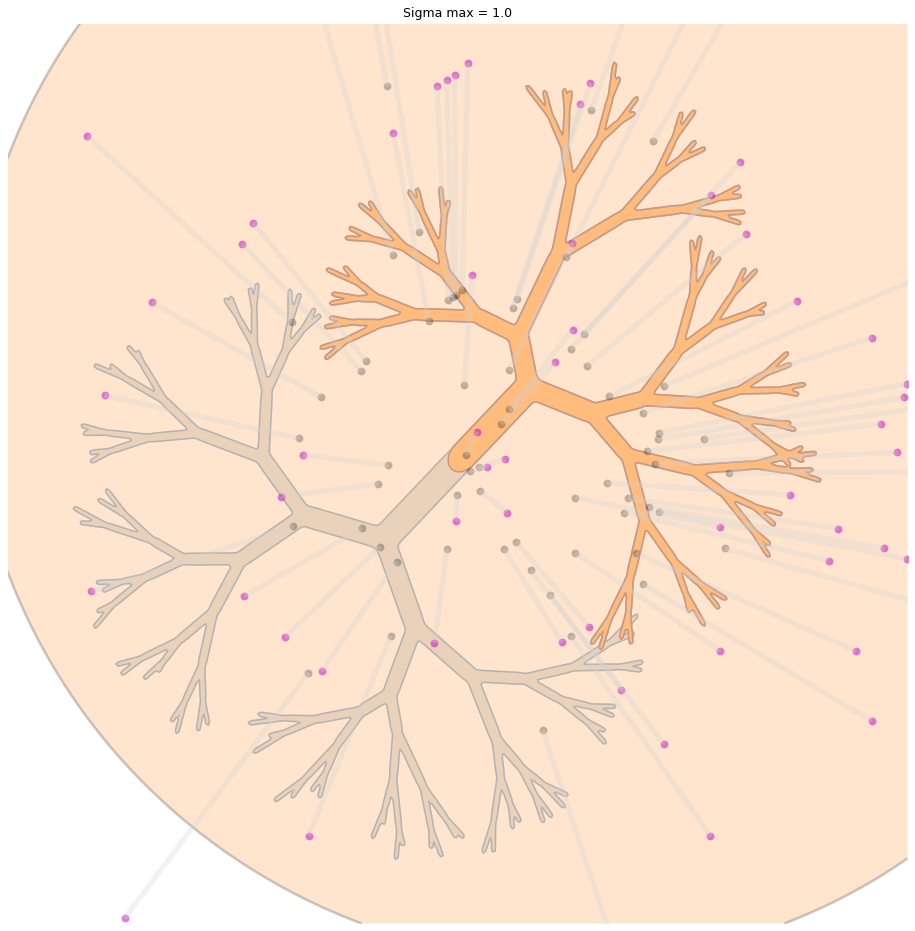

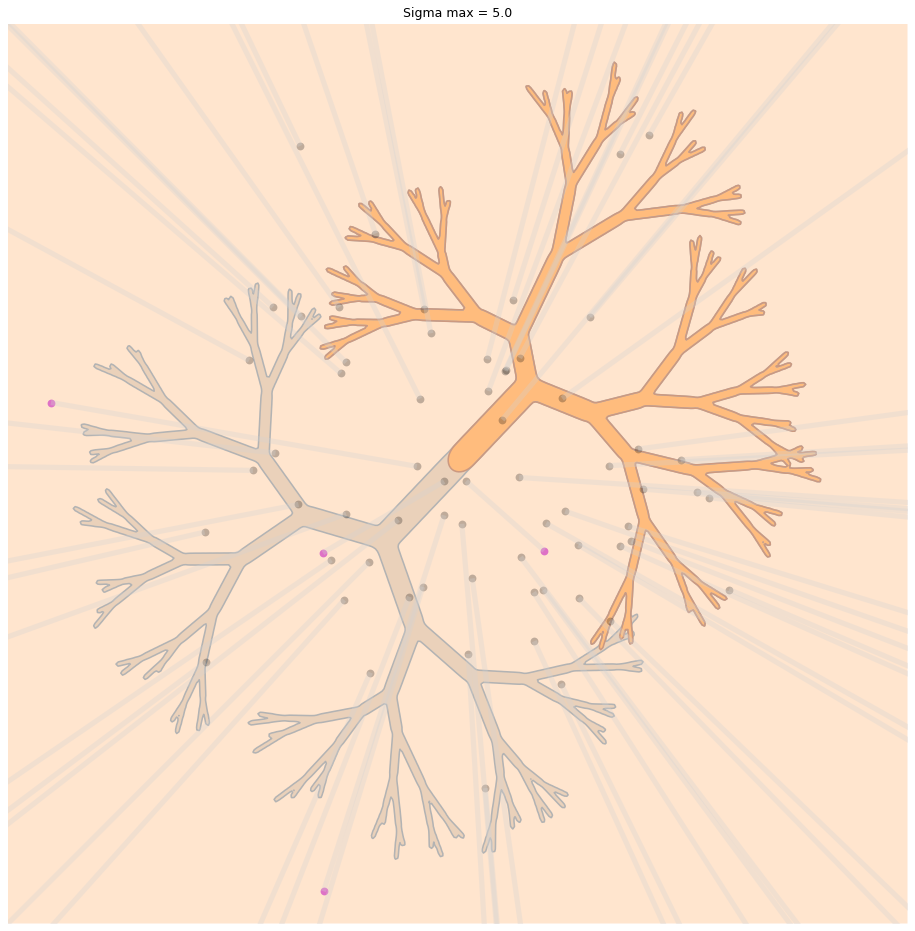

In [19]:
for sigma_max in [0.5,1,5]:
    plt.figure(figsize=[12, 12], dpi=75)
    toy.do_plot(ema, elems={'samples_before_small',
                            'trajectories_small', 'samples',
                            'gt_smax',
                            'gt_uncond', 'gt_outline'}, num_samples=1<<6, sigma_max=sigma_max)
    plt.title(f"Sigma max = {sigma_max:.1f}")

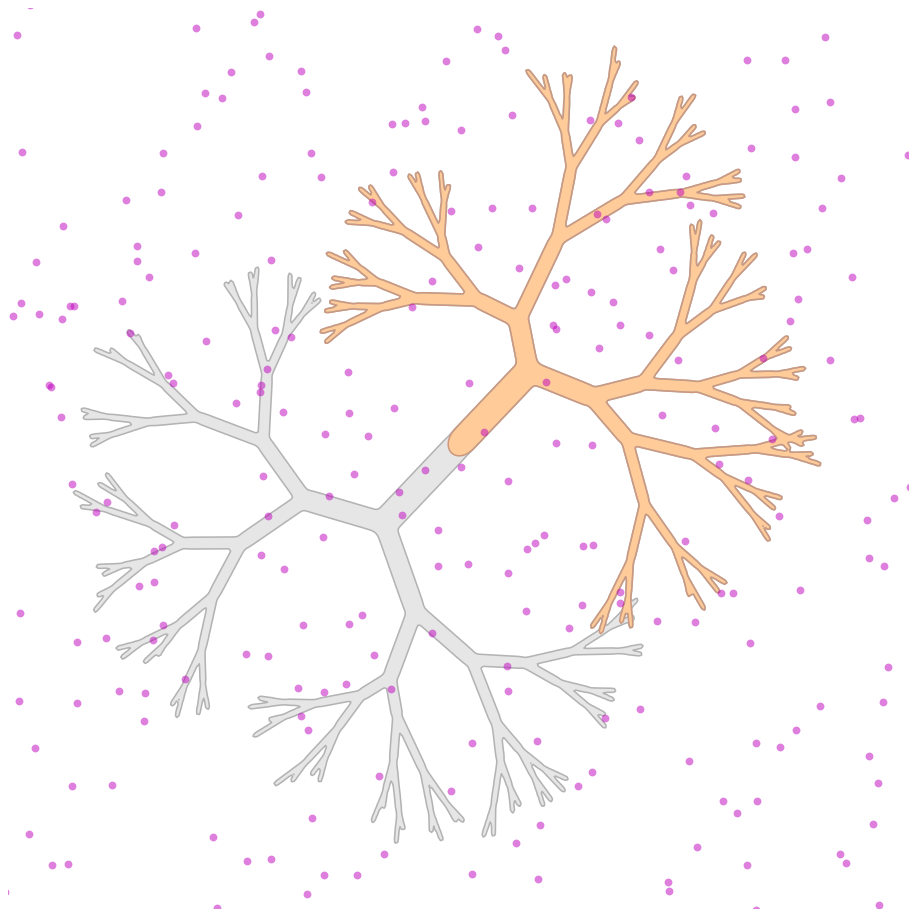

In [ ]:
plt.figure(figsize=[12, 12], dpi=75)
toy.do_plot(ema, elems={'samples_before_small','gt_uncond', 'gt_outline'}, num_samples=1<<12)

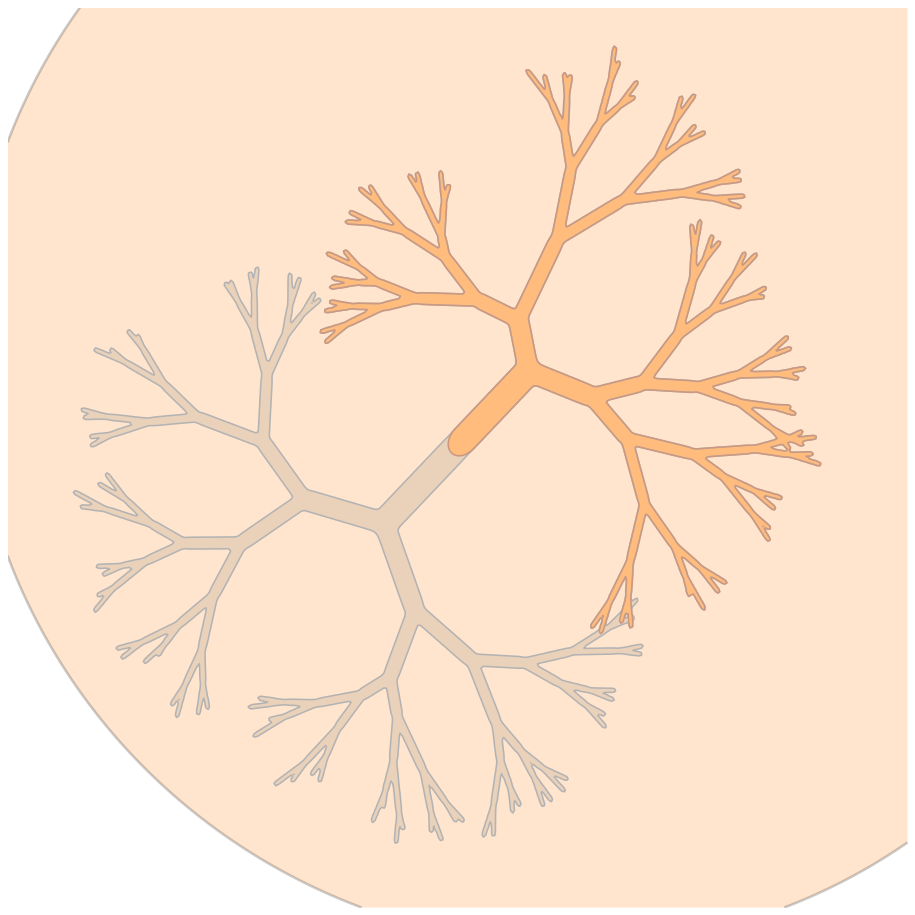

In [15]:
plt.figure(figsize=[12, 12], dpi=75)
toy.do_plot(ema, elems={'gt_smax','gt_uncond', 'gt_outline'}, num_samples=1<<12, sigma_max=1)